__BIOBSS - ECG Signal Processing__

_This notebook includes guidelines to help using BIOBSS for ECG signal processing and feature extraction._

In [1]:
#Import BIOBSS and the other required packages

import biobss
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

c:\Users\ipek.karakus\.conda\envs\biolib\lib\site-packages\plotly_resampler\aggregation\aggregators.py:24: UserWarning: Could not import lttbc; will use a (slower) python alternative.
  warnings.warn("Could not import lttbc; will use a (slower) python alternative.")


# Table of Contents
1. [ECG Sample Data](#sampledata)<br>
2. [ECG Signal Preprocessing](#ecg_pre)<br>
    2.1. [Filtering](#ecg_filter)<br>
    2.2. [Peak Detection](#ecg_peak)<br>
    2.3. [Delineation](#ecg_waves)<br>
4. [ECG Signal Quality Assessment](#ecg_sqa)<br>
    4.1. [Clipping and Flatline Detection](#ecg_cf)<br>
    4.2. [Physiological Limits](#ecg_pm)<br>
    4.3. [Template Matching](#ecg_tm)<br>
5. [ECG Feature Extraction](#ecg_features)<br>
    5.1. [Features from R peaks](#ecg_f_rpeaks)<br>
    5.2. [Features from P, Q, R, S, T waves](#ecg_f_waves)<br>

### __ECG Sample Data__
<a id="sampledata"></a>

ECG sample data is provided as a csv file in BIOBSS\sample data. The data file contains an ECG signal of 5 minutes length, sampled at 256 Hz.

In [2]:
#Load the sample data.

data_dir = os.path.join(os.path.normpath(os.getcwd() + os.sep + os.pardir),"sample_data")
filename='ecg_sample_data.csv'

data=pd.read_csv(os.path.join(data_dir,filename))
#Select the first segment to be used in the examples
fs=256
L=10
sig=np.asarray(data.iloc[:fs*L,0]) 

### __ECG Signal Preprocessing__
<a id="ecg_pre"></a>

#### __Filtering__
<a id="ecg_filter"></a>

BIOBSS provides a filtering function which uses Scipy. This function can be used to implement Butterworth filter by defining the filter parameters (filter type, filter order, cutoff frequencies) as shown below.

In [3]:
#Filter ECG signal by defining the filter parameters
f_sig= biobss.preprocess.filter_signal(sig,fs,'bandpass',N=2,f_lower=0.5,f_upper=5)

As an alternative, predefined filters can be used for each signal type. In order to use this option for ECG signal, signal_type should be selected as 'ECG'. 

In [ ]:
#Filter ECG signal by using predefined filters
filtered_ecg=biobss.preprocess.filter_signal(sig, sampling_rate=fs, signal_type='ECG', method='elgendi')

#### __Peak Detection__
<a id="ecg_peak"></a>

BIOBSS provides a specialized peak detection function for ECG signal. The function uses 'ecgdetectors' package to implement methods and returns a dictionary of R-peak locations and amplitudes.

In [4]:
#Detect peaks using 'pantompkins' method.
locs_peaks=biobss.ecgtools.ecg_peaks(sig,fs,'pantompkins')
peaks = sig[locs_peaks]

#### __Delineation__
<a id="ecg_waves"></a>

Since ECG signal has a complex waveform including P wave, QRS complex and T wave; BIOBSS also provides a delineation function. This function uses 'neurokit2' method from Neurokit2 package and returns a dictionary of all fiducial locations. The function requires R-peak locations to calculate the fiducial locations. If peaks_locs is not provided, the function calculates the locations itself using 'pantompkins' method.

In [7]:
#Delineate ECG signal using 'neurokit2' method. 

fiducials = biobss.ecgtools.ecg_waves(sig=sig, sampling_rate=fs, delineator='neurokit2')

p_peaks_locs = fiducials['ECG_P_Peaks']
q_peaks_locs = fiducials['ECG_Q_Peaks']
s_peaks_locs = fiducials['ECG_S_Peaks']
t_peaks_locs = fiducials['ECG_T_Peaks']
p_onset_locs = fiducials['ECG_P_Onsets']
t_offset_locs = fiducials['ECG_T_Offsets']

BIOBSS provides plotting functions specific to each signal type. In order to plot ACC signals, ___plot_ecg___ function can be used. The signals and peaks should be provided as dictionaries, and the keys should be selected as in documentation. The plots can be generated either using __Matplotlib__ or __Plotly__. 

In [8]:
#Generate inputs as dictionaries
signals={'Raw': sig, 'Filtered': f_sig}
peaks={'Ppeaks': {'Location':p_peaks_locs, 'Amplitude': sig[p_peaks_locs]}, 'Qpeaks': {'Location':q_peaks_locs, 'Amplitude': sig[q_peaks_locs]}, 'Rpeaks': {'Location':locs_peaks, 'Amplitude': peaks}}

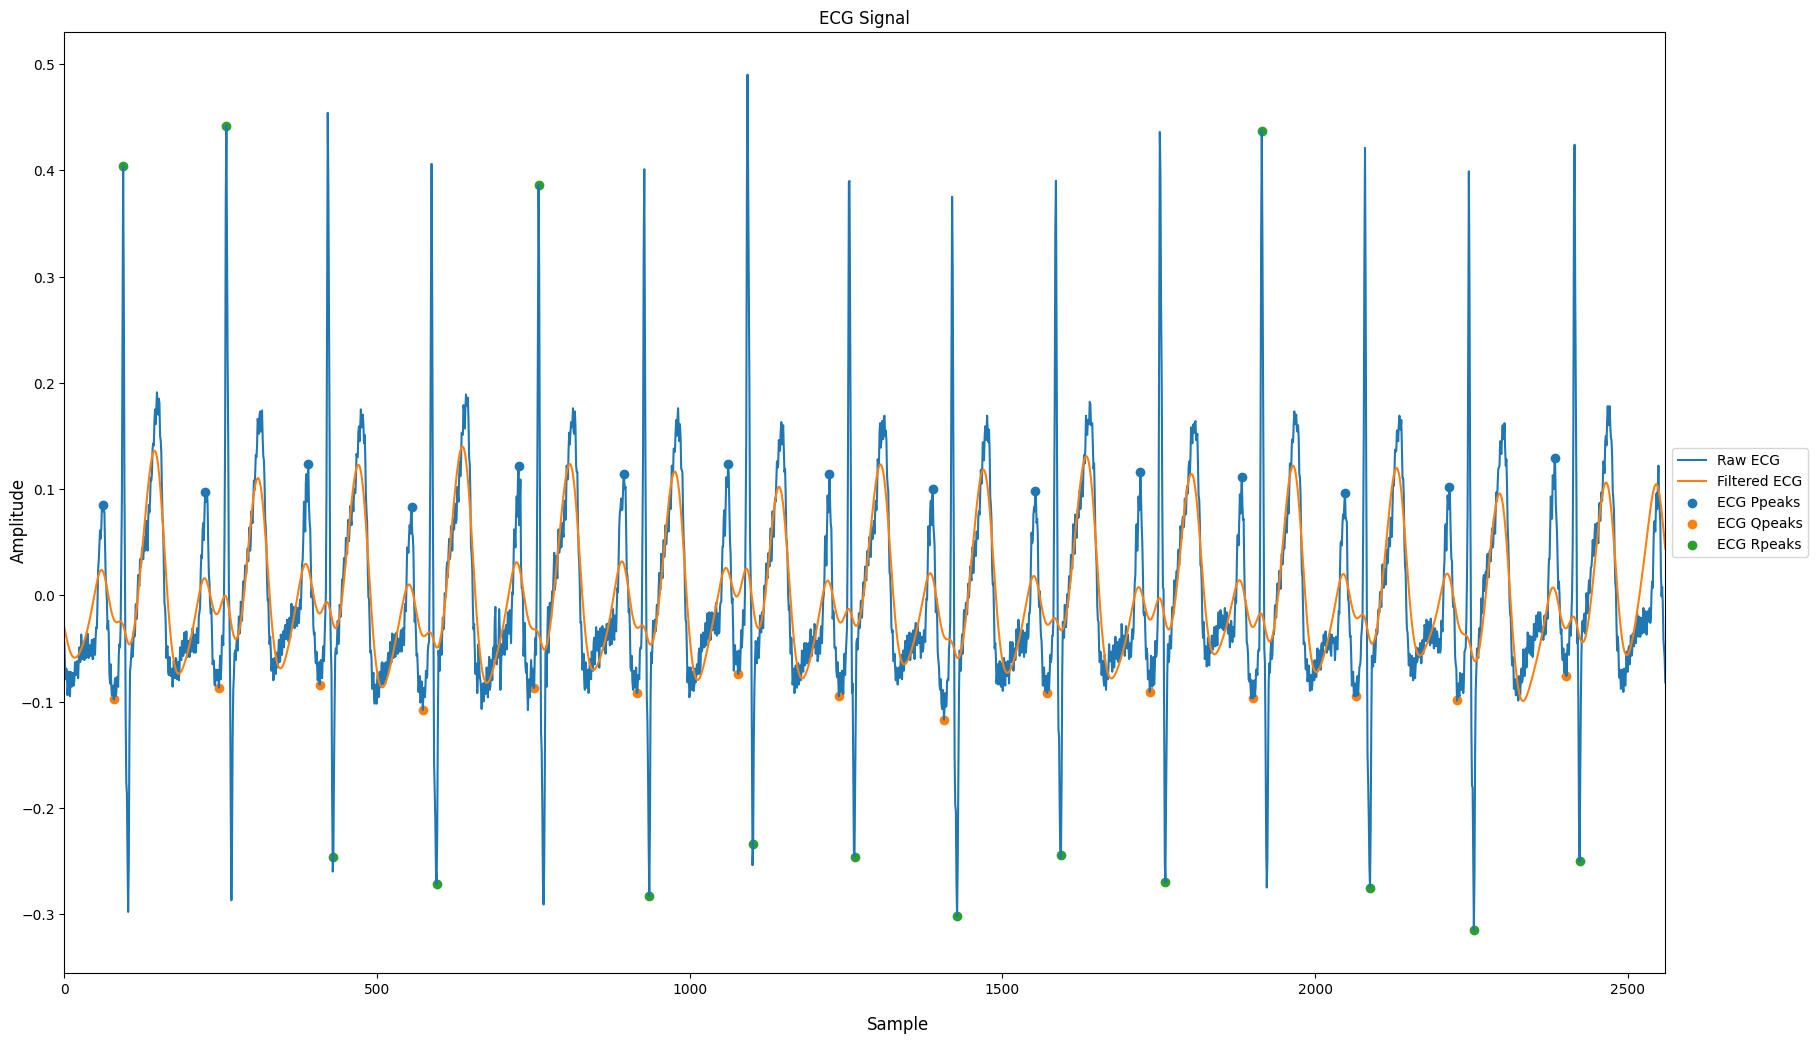

In [9]:
#Plot ECG signal
biobss.ecgtools.plot_ecg(signals=signals, peaks=peaks, show_peaks=True)

In [10]:
#Plot ECG signal using Plotly
biobss.ecgtools.plot_ecg(signals=signals, peaks=peaks, method='plotly', show_peaks=True)

### __ECG Signal Quality Assessment__
<a id="ecg_sqa"></a>

Signal quality assessment is an important step which should be applied prior to signal analysis. For this purpose, rule-based or machine learning based approaches can be applied based on the morphological information from ECG waveform. BIOBSS provides a set of functions for assessing signal quality, which can be applied seperately or consecutively.

#### __Clipping and Flatline Detection__
<a id="ecg_cf"></a>

The ___detect_flatline_clipping___ function is used to detect clipped or flat segments of a signal by setting the parameters and returns a dictionary of boundaries. 

Clipping occurs because of exceeding voltage limits of the signal conditioning circuits. Clipped segments can be detected by setting a threshold and applying rules on the signal amplitude. 

In [ ]:
#Detect clipped segments of ECG signal by setting a threshold value for signal amplitude
info=biobss.sqatools.detect_flatline_clipping(sig,threshold=1.0, clipping=True)

Flatline detection differs from clipping such that it can occur at any level of signal amplitude and duration of flat segments also matters to detect flatlines. Thus, both an amplitude and duration threshold should be defined to apply the rules. Note that, threshold of signal amplitude is defined as the minimum level of amplitude change required for a signal to be considered as non-flat segment.

In [ ]:
#Detect flat segments of ECG signal by setting thresholds for signal amplitude change and duration of flat segments
info=biobss.sqatools.detect_flatline_clipping(sig,threshold=0.0001, flatline=True, duration=10)

#### __Physiological Limits__
<a id="ecg_pm"></a>

The ___check_phys___ function can be used to check for physiological limits. This function takes R-peak locations as argument and return a dictionary of boolean results of the applied rules.

In [ ]:
#Peak detection
locs_peaks=biobss.ecgtools.ecg_peaks(sig,fs,'pantompkins')
peaks = sig[locs_peaks]

Now, the phsyiological limits can be compared to the accepted values in the literature. 
Reference: https://link.springer.com/book/10.1007/978-3-319-68415-4

These values are defined as constants in the corresponding modules as given below. 

Physiological limits:
- HR_MIN = 40 #minimum heart rate
- HR_MAX = 180 #maximum heart rate
- PP_MAX = 3 #maximum peak to peak interval
- MAX_PP_RATIO = 2.2 #maximum P-P interval / minimum P-P interval 


In [ ]:
#Check for physiological limits
info=biobss.sqatools.check_phys(locs_peaks,fs)

#### __Template Matching__
<a id="ecg_tm"></a>

A common method for signal quality assessment is known as "Template Matching". This method is based on the expectation that pulse waveforms will have similar morphology in an ECG segment. A template is generated by aligning the pulses by their R-peaks and averaging them. Then, similarity of each pulse with the template is assessed using a measure. The ___template_matching___ function uses Pearson correlation as similarity measure. A threshold should be determined for correlation coefficient below which the pulse is "unacceptable". The default value is setted as 0.9 for the threshold. The function returns a tuple of correlation coefficients and a boolean result for the quality of the segment.

In [ ]:
#Template matching 
info=biobss.sqatools.template_matching(sig,locs_peaks)

The methods defined above can also be applied simultaneously using the function ___ecg_sqa___. Methods can be provided as a list and the function returns a dictionary of results. 

In [ ]:
info=biobss.ecgtools.ecg_sqa(ecg_sig=sig, sampling_rate=fs, methods=['clipping', 'flatline','physiological','template'], clipping_threshold=1.0, flatline_threshold=0.0001, duration=10, peaks_locs=locs_peaks)

### __ECG Feature Extraction__
<a id="ecg_features"></a>

ECG signal is mostly used for heart rate variability analysis and arrhythmia classification in the literature. For arrhythmia classification, morphological/time domain features are commonly used to train the machine learning models. BIOBSS package provides a set of functions for calculation of the most common ECG features in the literature. Some features can be calculated using only R-peak locations while others requires information on all fiducial points. 

#### __Features from R peaks__
<a id="ecg_f_rpeaks"></a>

The ___from_Rpeaks___ function calculates morphological features using R-peak locations. These features are:
- 'a_R': Amplitude of R peak
- 'RR0': Previous RR interval
- 'RR1': Current RR interval
- 'RR2': Subsequent RR interval
- 'RRm': Mean of RR0, RR1 and RR2
- 'RR_0_1': Ratio of RR0 to RR1
- 'RR_2_1': Ratio of RR2 to RR1
- 'RR_m_1': Ratio of RRm to RR1

In [ ]:
#Calculate features from R peaks
features_rpeaks = biobss.ecgtools.ecg_features.from_Rpeaks(sig, locs_peaks, fs)

#### __Features from P, Q, R, S, T waves__
<a id="ecg_f_waves"></a>

The ___from_waves___ function calculates morphological features using locations of P, Q, R, S, T waves. These features are:
- 't_PR': Time between P and R peak locations
- 't_QR': Time between Q and R peak locations
- 't_SR': Time between S and R peak locations
- 't_TR': Time between T and R peak locations
- 't_PQ': Time between P and Q peak locations
- 't_PS': Time between P and S peak locations
- 't_PT': Time between P and T peak locations
- 't_QS': Time between Q and S peak locations
- 't_QT':Time between Q and T peak locations
- 't_ST': Time between S and T peak locations
- 't_PT_QS': Ratio of t_PT to t_QS
- 't_QT_QS': Ratio of t_QT to t_QS
- 'a_PQ': Difference of P wave and Q wave amplitudes
- 'a_QR': Difference of Q wave and R wave amplitudes
- 'a_RS': Difference of R wave and S wave amplitudes
- 'a_ST': Difference of S wave and T wave amplitudes
- 'a_PS': Difference of P wave and S wave amplitudes
- 'a_PT': Difference of P wave and T wave amplitudes
- 'a_QS': Difference of Q wave and S wave amplitudes
- 'a_QT': Difference of Q wave and T wave amplitudes
- 'a_ST_QS': Ratio of a_ST to a_QS
- 'a_RS_QR': Ratio of a_RS to a_QR
- 'a_PQ_QS': Ratio of a_PQ to a_QS
- 'a_PQ_QT': Ratio of a_PQ to a_QT
- 'a_PQ_PS': Ratio of a_PQ to a_PS
- 'a_PQ_QR': Ratio of a_PQ to a_QR
- 'a_PQ_RS': Ratio of a_PQ to a_RS
- 'a_RS_QS': Ratio of a_RS to a_QS
- 'a_RS_QT': Ratio of a_RS to a_QT
- 'a_ST_PQ': Ratio of a_ST to a_PQ
- 'a_ST_QT': Ratio of a_ST to a_QT

In [ ]:
#Calculate features from P, Q, R, S, T waves
features_waves = biobss.ecgtools.ecg_features.from_waves(sig, locs_peaks, fiducials, fs)